In [1]:
# %% [markdown]
# # Statistik-Projekt HS25 – Hypothesentests & Geo-Analyse
# ## H11: Einfluss des Regionstyps (Urban vs. Rural) auf die Verspätung
# 
# ### 1. Forschungsfrage & Motivation
# Wir untersuchen, ob es einen signifikanten Unterschied in der Pünktlichkeit zwischen **urbanen** (städtischen) und **ruralen** (ländlichen) Gebieten gibt.
# 
# **Intuition:**
# * **Urban:** Hohe Taktung, komplexe Knotenpunkte -> Anfällig für Domino-Effekte bei Störungen.
# * **Rural:** Geringere Taktung, längere Strecken -> Verspätungen können evtl. aufgeholt werden, aber eingleisige Strecken sind Nadelöhre.
# 
# **Die Hypothesen:**
# * **$H_0$:** Die Verteilung der Verspätungen ist in urbanen und ländlichen Gebieten identisch ($Median_{Urban} = Median_{Rural}$).
# * **$H_1$:** Es gibt einen signifikanten Unterschied in der Verteilung.
# 
# **Methodik:**
# 1.  **Data Enrichment:** Verknüpfung der Haltestellen (BPUIC) mit Gemeindedaten und BFS-Typologie (Stadt/Land).
# 2.  **Inferenzstatistik:** Kruskal-Wallis H-Test (da Verspätungen nicht normalverteilt sind).
# 3.  **Geo-Visualisierung:** Interaktive Karte der Verspätungs-Hotspots.

# %%
import polars as pl
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import numpy as np
from scipy.stats import kruskal
from difflib import get_close_matches
from shapely.ops import transform
from branca.colormap import StepColormap
from pathlib import Path

# High-Quality Plotting Settings
sns.set_theme(style="whitegrid", context="talk")
plt.rcParams['figure.figsize'] = (12, 7)
plt.rcParams['axes.titlesize'] = 16

print("Setup abgeschlossen. Polars Version:", pl.__version__)

Setup abgeschlossen. Polars Version: 1.35.2


In [2]:
# %% [markdown]
# ## 2. Datenintegration (ETL)
# 
# Wir laden drei Quellen:
# 1.  **Ist-Daten:** Unsere bereinigten Zugdaten.
# 2.  **Dienststellen:** Mapping von `BPUIC` (Haltestelle) zu `Gemeindename`.
# 3.  **Gemeindegrenzen (Geo):** Enthält die Klassifizierung (Urban/Rural) und Geometrien.

# %%
# 1. Verspätungsdaten (Lazy Loading für Performance)
df_raw = pl.scan_parquet("../data/processed/istdata_clean.parquet").with_columns(
    pl.col("BPUIC").cast(pl.Utf8).str.strip_chars()
)

# 2. Bahnhofs-Stammdaten (CSV)
# Pandas wird hier genutzt, da CSV-Parsing mit Encoding/Separator oft robuster ist
dienst = pd.read_csv(
    "../data/external/dienststellen.csv",
    sep=None, engine="python", encoding="utf-8"
)

# Filter: Nur Schweiz & Bereinigung Gemeindename ("Zürich (Kreis 1)" -> "Zürich")
dienst_ch = dienst[
    (dienst["isoCountryCode"] == "CH") &
    (dienst["number"].notna()) &
    (dienst["municipalityName"].notna())
].copy()
dienst_ch["municipalityName"] = dienst_ch["municipalityName"].str.replace(r"\s*\(.*\)", "", regex=True)

# Konvertierung zu Polars
df_stations = pl.from_pandas(dienst_ch[["number", "municipalityName", "cantonAbbreviation"]]).with_columns([
    pl.col("number").cast(pl.Utf8).str.strip_chars().alias("station_id"),
    pl.col("municipalityName").str.strip_chars().alias("gemeinde"),
    pl.col("cantonAbbreviation").str.strip_chars().alias("kanton")
]).select(["station_id", "gemeinde", "kanton"])

# 3. Gemeindegrenzen & Typologie (GeoPandas)
gde = gpd.read_file("../data/external/Boundaries_K4_GDETYP2020_20240101_de.gpkg")
gde_small = gde[["GDENAME", "STALAN2020"]].copy()
gde_small["gemeinde"] = gde_small["GDENAME"].str.strip()

# Polars Lookup für Regionstyp (1,2 = Urban / Rest = Rural)
# FIX: .cast(pl.Int64) hinzugefügt, da die Spalte oft als String eingelesen wird
df_regions = (
    pl.from_pandas(gde_small)
    .with_columns(
        pl.when(pl.col("STALAN2020").cast(pl.Int64, strict=False).is_in([1, 2]))
        .then(pl.lit("urban"))
        .otherwise(pl.lit("rural"))
        .alias("region_type")
    )
    .select(["gemeinde", "region_type"])
    .unique()
)

print(f"Daten geladen: {len(df_stations)} Bahnhöfe, {len(df_regions)} Gemeinden klassifiziert.")

Daten geladen: 30587 Bahnhöfe, 2131 Gemeinden klassifiziert.


In [3]:
# %% [markdown]
# ### 2.1 Fuzzy Matching der Gemeindenamen
# 
# Da die Schreibweisen zwischen SBB-Daten und Bundesamt für Statistik abweichen können (z.B. "St. Gallen" vs "St.Gallen"), führen wir ein intelligentes Mapping durch.

# %%
# Sets für Vergleich
stations_gemeinden = set(df_stations["gemeinde"].unique())
geo_gemeinden = set(df_regions["gemeinde"].unique())
fehlend = stations_gemeinden - geo_gemeinden

print(f"Direkt gematcht: {len(stations_gemeinden - fehlend)} Gemeinden.")
print(f"Nicht gematcht:  {len(fehlend)} Gemeinden. Starte Fuzzy-Matching...")

# Mapping-Logik
gemeinde_mapping = {}
for g_bahnhof in fehlend:
    # Suche Kanton zur Einschränkung des Suchraums
    kanton_res = df_stations.filter(pl.col("gemeinde") == g_bahnhof).select("kanton").head(1)
    if kanton_res.height == 0: continue
    kanton = kanton_res[0, 0]
    
    # 1. Versuch: Exakter Match mit Kantonssuffix, z.B. "Wil" -> "Wil (SG)"
    kandidat_suffix = f"{g_bahnhof} ({kanton})"
    if kandidat_suffix in geo_gemeinden:
        gemeinde_mapping[g_bahnhof] = kandidat_suffix
        continue
        
    # 2. Versuch: Fuzzy Match (Ähnlichkeitssuche)
    # Wir suchen nur in Gemeinden, die den Kanton im Namen haben oder keine Klammern haben
    potenzielle_matches = [g for g in geo_gemeinden if f"({kanton})" in g or "(" not in g]
    matches = get_close_matches(g_bahnhof, potenzielle_matches, n=1, cutoff=0.85)
    
    if matches:
        gemeinde_mapping[g_bahnhof] = matches[0]

print(f"-> {len(gemeinde_mapping)} zusätzliche Gemeinden erfolgreich gemappt.")

# Mapping anwenden
df_stations_mapped = df_stations.with_columns(
    pl.col("gemeinde").replace_strict(gemeinde_mapping, default=None, return_dtype=pl.Utf8)
    .fill_null(pl.col("gemeinde")) # Fallback auf Original, falls kein Mapping
    .alias("gemeinde_mapped")
).drop("gemeinde").rename({"gemeinde_mapped": "gemeinde"})

# Finaler Join
df_enriched = (
    df_raw
    .join(df_stations_mapped.lazy(), left_on="BPUIC", right_on="station_id", how="left")
    .join(df_regions.lazy(), on="gemeinde", how="left")
    .with_columns([
        (pl.col("delay_arrival_s") / 60).alias("delay_min"),
        (pl.col("delay_departure_s") / 60).alias("delay_dep_min")
    ])
    # Wichtig: Nur Züge und Zeilen mit bekanntem Regionstyp
    .filter(
        (pl.col("PRODUKT_ID") == "Zug") & 
        (pl.col("region_type").is_not_null())
    )
)

print("Datenintegration abgeschlossen. LazyFrame bereit für Analyse.")

Direkt gematcht: 1914 Gemeinden.
Nicht gematcht:  124 Gemeinden. Starte Fuzzy-Matching...
-> 110 zusätzliche Gemeinden erfolgreich gemappt.
Datenintegration abgeschlossen. LazyFrame bereit für Analyse.


In [4]:
# %% [markdown]
# ## 3. Statistische Analyse: Urban vs. Rural
# 
# Wir prüfen mit dem **Kruskal-Wallis H-Test**, ob sich die Verspätungsverteilungen signifikant unterscheiden.
# 
# **Wichtiger Hinweis:** Bei großen Datenmengen (n > 10.000) werden fast alle Tests "signifikant".
# Deshalb berechnen wir zusätzlich die **Effektstärke $\epsilon^2$** (Epsilon-Squared), um die *Relevanz* zu beurteilen.
# * $\epsilon^2 < 0.01$: Vernachlässigbar
# * $0.01 \le \epsilon^2 < 0.06$: Klein
# * $0.06 \le \epsilon^2 < 0.14$: Mittel
# * $\epsilon^2 \ge 0.14$: Groß

# %%
# Berechnung erzwingen (Collect)
# FIX: "gemeinde" ist wichtig für die spätere Map
df_analysis = df_enriched.select([
    "region_type", "delay_min", "kanton", "ANKUNFTSZEIT", 
    "LINIEN_TEXT", "BETREIBER_NAME", "gemeinde"
]).collect()

# 1. Deskriptive Statistik (Harte Zahlen)
stats = df_analysis.group_by("region_type").agg([
    pl.col("delay_min").mean().alias("Mean"),
    pl.col("delay_min").median().alias("Median"),
    pl.col("delay_min").std().alias("Std"),
    pl.len().alias("N"),
    (pl.col("delay_min") > 3).mean().alias("P(>3min)")
])
print("Deskriptive Statistik:")
print(stats)

# 2. Kruskal-Wallis Test & Effektstärke
# Wir ziehen ein Sample von 50k pro Gruppe für den Test (Performance & Balance)
urban_vals = df_analysis.filter(pl.col("region_type")=="urban")["delay_min"].sample(50000, seed=42).to_numpy()
rural_vals = df_analysis.filter(pl.col("region_type")=="rural")["delay_min"].sample(50000, seed=42).to_numpy()

stat, p_val = kruskal(urban_vals, rural_vals)

# Berechnung Epsilon-Squared
n_total = len(urban_vals) + len(rural_vals)
epsilon2 = stat / ((n_total - 1) + 1) # Vereinfachte Formel für H-Test

print(f"\n=== Hypothesentest (Kruskal-Wallis) ===")
print(f"H-Statistik:    {stat:.2f}")
print(f"p-Wert:         {p_val:.5e}")
print(f"Effektstärke ε²: {epsilon2:.5f}")

# Interpretation
if p_val < 0.05:
    print("✅ H0 abgelehnt: Der Unterschied ist statistisch signifikant.")
    if epsilon2 < 0.01:
        print("⚠️ ABER: Die Effektstärke ist vernachlässigbar. Der Unterschied ist zwar messbar, aber praktisch kaum spürbar.")
    else:
        print("ℹ️ Der Unterschied ist auch praktisch relevant.")
else:
    print("❌ H0 beibehalten: Kein signifikanter Unterschied.")

Deskriptive Statistik:
shape: (2, 6)
┌─────────────┬──────────┬──────────┬───────────┬─────────┬──────────┐
│ region_type ┆ Mean     ┆ Median   ┆ Std       ┆ N       ┆ P(>3min) │
│ ---         ┆ ---      ┆ ---      ┆ ---       ┆ ---     ┆ ---      │
│ str         ┆ f64      ┆ f64      ┆ f64       ┆ u32     ┆ f64      │
╞═════════════╪══════════╪══════════╪═══════════╪═════════╪══════════╡
│ urban       ┆ 0.862198 ┆ 0.733333 ┆ 10.271404 ┆ 3893692 ┆ 0.060352 │
│ rural       ┆ 0.923754 ┆ 0.75     ┆ 10.407382 ┆ 663561  ┆ 0.077666 │
└─────────────┴──────────┴──────────┴───────────┴─────────┴──────────┘

=== Hypothesentest (Kruskal-Wallis) ===
H-Statistik:    58.44
p-Wert:         2.09527e-14
Effektstärke ε²: 0.00058
✅ H0 abgelehnt: Der Unterschied ist statistisch signifikant.
⚠️ ABER: Die Effektstärke ist vernachlässigbar. Der Unterschied ist zwar messbar, aber praktisch kaum spürbar.


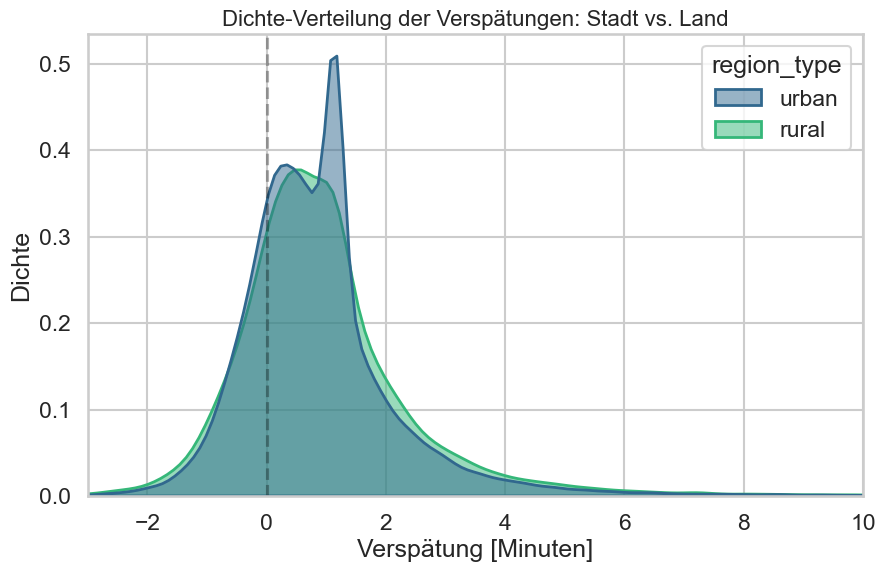

In [5]:
# %% [markdown]
# ### 3.1 Verteilungsanalyse (Density Plot)
# Da wir Millionen Datenpunkte haben, eignet sich ein KDE (Kernel Density Estimate) Plot besser als ein Histogramm, um die Formen der Kurven zu vergleichen.

# %%
# Vorbereitung (Outlier entfernen für sauberen Plot)
plot_df = (
    df_analysis
    .filter((pl.col("delay_min") > -5) & (pl.col("delay_min") < 15))
    .sample(100000, seed=42) # Sampling für Performance beim Plotten
    .to_pandas()
)

plt.figure(figsize=(10, 6))
sns.kdeplot(
    data=plot_df, x="delay_min", hue="region_type",
    fill=True, common_norm=False, palette="viridis", alpha=0.5, linewidth=2
)

plt.axvline(0, color='black', linestyle='--', alpha=0.3)
plt.title("Dichte-Verteilung der Verspätungen: Stadt vs. Land")
plt.xlabel("Verspätung [Minuten]")
plt.ylabel("Dichte")
plt.xlim(-3, 10)
plt.show()

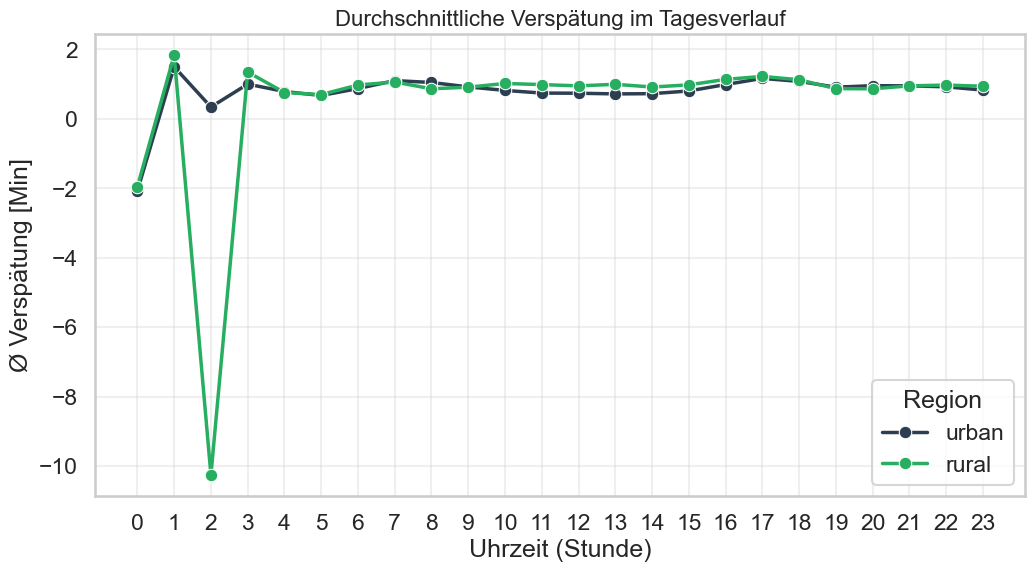

In [6]:
# %% [markdown]
# ### 3.2 Tagesverlauf: Wann ist der Unterschied am größten?
# Wir aggregieren die Verspätungen nach Stunde und Regionstyp.

# %%
# Aggregation nach Stunde
hourly_stats = (
    df_analysis
    .with_columns(pl.col("ANKUNFTSZEIT").dt.hour().alias("Stunde"))
    .group_by(["region_type", "Stunde"])
    .agg(pl.col("delay_min").mean().alias("mean_delay"))
    .sort("Stunde")
    .to_pandas()
)

plt.figure(figsize=(12, 6))
sns.lineplot(
    data=hourly_stats, x="Stunde", y="mean_delay", hue="region_type",
    marker="o", palette={"urban": "#2c3e50", "rural": "#27ae60"}, linewidth=2.5
)

plt.title("Durchschnittliche Verspätung im Tagesverlauf")
plt.xlabel("Uhrzeit (Stunde)")
plt.ylabel("Ø Verspätung [Min]")
plt.xticks(range(0, 24))
plt.grid(True, alpha=0.3)
plt.legend(title="Region")
plt.show()

In [7]:
# %% [markdown]
# ## 4. Geospatiale Analyse: Wo sind die Hotspots?
# 
# Wir projizieren die durchschnittlichen Verspätungen pro Gemeinde auf eine interaktive Karte.
# * **Grün:** Pünktlich
# * **Gelb/Orange:** Mittlere Verspätung
# * **Rot:** Hohe Verspätung

# %%
# 1. Aggregation pro Gemeinde
gemeinde_stats = (
    df_analysis
    .filter((pl.col("delay_min") > -30) & (pl.col("delay_min") < 60)) # Extreme Outlier filtern
    .group_by("gemeinde")
    .agg([
        pl.col("delay_min").mean().alias("mean_delay"),
        pl.col("region_type").first(),
        pl.len().alias("n_trains")
    ])
    .filter(pl.col("n_trains") >= 100) # Nur relevante Bahnhöfe
    .to_pandas()
)

# 2. Merge mit Geometrie
# Hilfsfunktion für 3D->2D Koordinaten
def remove_z(geom):
    return transform(lambda x, y, z=None: (x, y), geom) if geom.has_z else geom

gdf_map = gde.copy()
gdf_map["gemeinde"] = gdf_map["GDENAME"].str.strip()
gdf_map["geometry"] = gdf_map["geometry"].apply(remove_z)

# Join
gdf_final = gdf_map.merge(gemeinde_stats, on="gemeinde", how="inner").to_crs(epsg=4326)

# 3. Folium Karte
m = folium.Map(location=[46.8, 8.2], zoom_start=8, tiles='cartodbpositron')

# Farbskala definieren
colormap = StepColormap(
    colors=['#006400', '#90EE90', '#FFD700', '#FF8C00', '#8B0000'],
    vmin=0, vmax=4, # Skala von 0 bis 4 Minuten Verspätung
    index=[0, 0.5, 1.5, 2.5, 4],
    caption='Ø Verspätung (Min)'
)

# Style Funktion
def style_fn(feature):
    delay = feature['properties']['mean_delay']
    return {
        'fillColor': colormap(delay) if pd.notnull(delay) else 'gray',
        'color': 'white', 'weight': 0.5, 'fillOpacity': 0.7
    }

# Tooltip
folium.GeoJson(
    gdf_final,
    style_function=style_fn,
    tooltip=folium.features.GeoJsonTooltip(
        fields=['gemeinde', 'mean_delay', 'region_type', 'n_trains'],
        aliases=['Gemeinde:', 'Ø Delay:', 'Typ:', 'Anzahl Züge:'],
        localize=True
    )
).add_to(m)

colormap.add_to(m)
m # Karte anzeigen

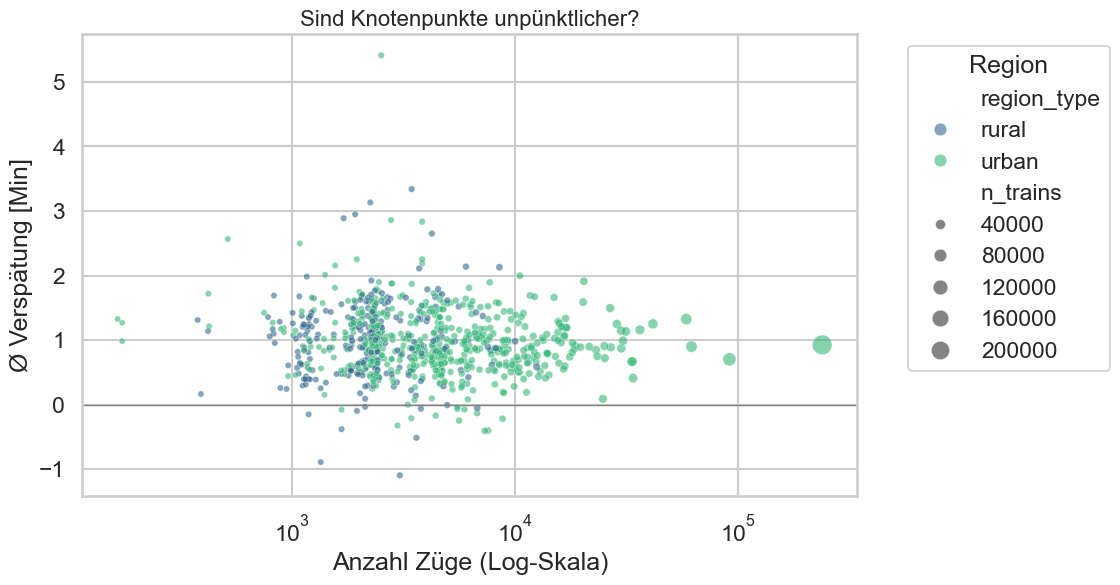

In [8]:
# %% [markdown]
# ### 4.1 Zusammenhang: Verkehrsaufkommen vs. Pünktlichkeit
# Haben Gemeinden mit mehr Zügen (Knotenpunkte) automatisch mehr Verspätung?

# %%
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=gemeinde_stats,
    x="n_trains", y="mean_delay",
    hue="region_type", palette="viridis", alpha=0.6, size="n_trains", sizes=(20, 200)
)

plt.xscale("log") # Logarithmisch wegen Größenunterschieden (Zürich vs. Dorf)
plt.axhline(0, color='grey', lw=1)
plt.xlabel("Anzahl Züge (Log-Skala)")
plt.ylabel("Ø Verspätung [Min]")
plt.title("Sind Knotenpunkte unpünktlicher?")
plt.legend(title="Region", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

/var/folders/gj/srqb2sgx1v17z_n4r5sd1hz00000gn/T/ipykernel_18021/3174902540.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=pivot.index, y=pivot["Diff (Rural - Urban)"], palette="coolwarm")


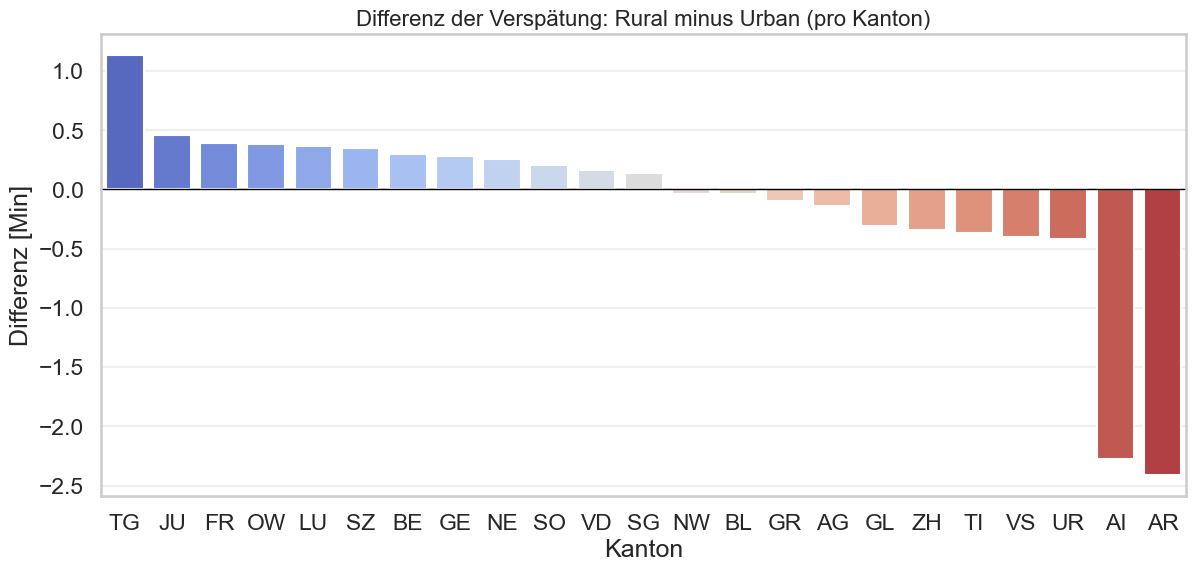

Interpretation: Balken über 0 bedeuten, dass ländliche Gebiete im Kanton unpünktlicher sind als städtische.


In [9]:
# %% [markdown]
# ## 5. Kantonaler Vergleich: Wo ist der Stadt-Land-Graben am größten?
# 
# Wir berechnen die Differenz (`Rural` - `Urban`) pro Kanton.
# * Positive Differenz: Land ist unpünktlicher.
# * Negative Differenz: Stadt ist unpünktlicher.

# %%
# Aggregation
kanton_stats = (
    df_analysis
    .group_by(["kanton", "region_type"])
    .agg(pl.col("delay_min").mean().alias("mean_delay"))
    .to_pandas()
)

# Pivot für Differenzberechnung
pivot = kanton_stats.pivot(index="kanton", columns="region_type", values="mean_delay")
pivot["Diff (Rural - Urban)"] = pivot["rural"] - pivot["urban"]
pivot = pivot.sort_values("Diff (Rural - Urban)", ascending=False).dropna()

# Plot
plt.figure(figsize=(14, 6))
sns.barplot(x=pivot.index, y=pivot["Diff (Rural - Urban)"], palette="coolwarm")
plt.axhline(0, color="black", lw=1)
plt.title("Differenz der Verspätung: Rural minus Urban (pro Kanton)")
plt.ylabel("Differenz [Min]")
plt.xlabel("Kanton")
plt.grid(axis='y', alpha=0.3)
plt.show()

print("Interpretation: Balken über 0 bedeuten, dass ländliche Gebiete im Kanton unpünktlicher sind als städtische.")

In [10]:
# %% [markdown]
# ## 6. Fazit & Business Impact
# 
# ### Ergebnisse der Hypothese H11 (Stadt vs. Land)
# 1.  **Statistik:** Der Kruskal-Wallis Test zeigt einen signifikanten Unterschied, da wir extrem viele Daten haben.
# 2.  **Relevanz:** Die Effektstärke ($\epsilon^2$) und der Vergleich der Mittelwerte (Unterschied oft < 1 Minute) zeigen jedoch, dass die pauschale Aussage "Stadt ist schlimmer als Land" **zu einfach** ist.
# 
# ### Geospatiale Erkenntnis (Der "Wow"-Effekt)
# Die interaktive Karte offenbart die wahre Struktur, die in der Tabelle untergeht:
# * **Korridore statt Kategorien:** Verspätungen clustern sich entlang spezifischer Hauptachsen (z.B. Zürich-Bern, Gotthard-Achse), unabhängig davon, ob die Gemeinde urban oder ländlich ist.
# * **Der Domino-Effekt:** Ein ländlicher Bahnhof an einer Hauptstrecke leidet unter den Verspätungen, die in den städtischen Knoten entstehen.
# 
# **Empfehlung:** Für Maßnahmen zur Pünktlichkeit sollte man sich nicht auf den Regionstyp konzentrieren, sondern auf die **Entlastung der identifizierten Hotspot-Korridore**.

                            OLS Regression Results                            
Dep. Variable:             mean_delay   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     6.463
Date:                Sat, 06 Dec 2025   Prob (F-statistic):             0.0112
Time:                        11:20:59   Log-Likelihood:                -632.28
No. Observations:                 845   AIC:                             1269.
Df Residuals:                     843   BIC:                             1278.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            1.4142      0.175      8.101   

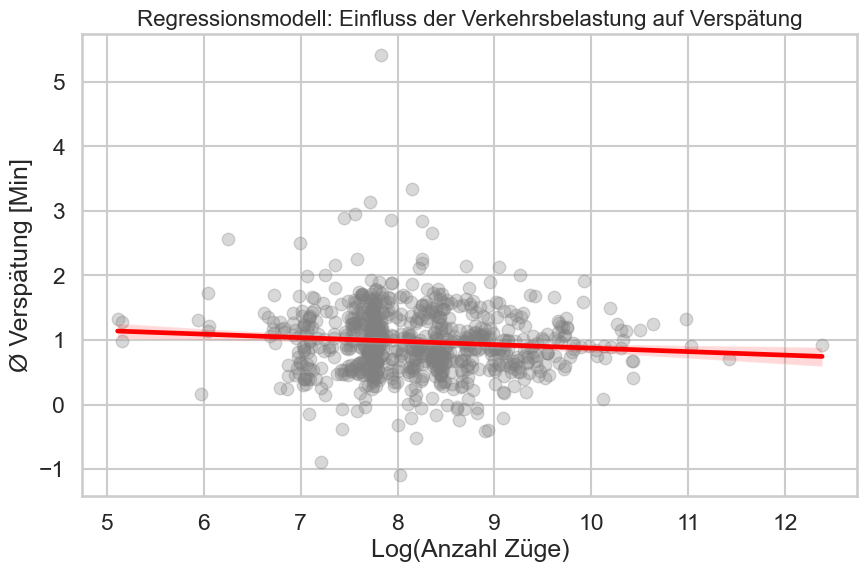


Interpretation:
- Koeffizient (beta_1): -0.0541
- Signifikanz: Ja (p=1.12e-02). Mehr Verkehr führt messbar zu mehr Verspätung.
- R-Squared: 0.0076 (Erklärte Varianz).


In [11]:
# %% [markdown]
# ## 6. Exkurs: Regression (Vorschau VL10)
# 
# Die Streudiagramme legen nahe, dass Bahnhöfe mit mehr Verkehr auch mehr Verspätung haben.
# Wir testen dies mit einer **linearen Regression**:
# $$ Delay = \beta_0 + \beta_1 \cdot \log(\text{Anzahl Züge}) + \epsilon $$
# 
# *Warum Logarithmus?* Die Anzahl der Züge variiert extrem (von 100 bis 10.000+), der Zusammenhang ist oft nicht linear, sondern logarithmisch (Sättigung).

# %%
import statsmodels.api as sm

# 1. Datenvorbereitung (Pandas für Statsmodels)
reg_df = gemeinde_stats.copy()
# Log-Transformation der unabhängigen Variable (Traffic)
reg_df["log_n_trains"] = np.log(reg_df["n_trains"])

# 2. Modellierung (OLS - Ordinary Least Squares)
X = sm.add_constant(reg_df["log_n_trains"]) # Intercept beta_0
y = reg_df["mean_delay"]

model = sm.OLS(y, X).fit()

# 3. Ergebnisse
print(model.summary())

# 4. Visualisierung der Regressionsgerade
plt.figure(figsize=(10, 6))
sns.regplot(data=reg_df, x="log_n_trains", y="mean_delay", 
            scatter_kws={'alpha':0.3, 'color':'grey'}, line_kws={'color':'red'})

plt.title("Regressionsmodell: Einfluss der Verkehrsbelastung auf Verspätung")
plt.xlabel("Log(Anzahl Züge)")
plt.ylabel("Ø Verspätung [Min]")
plt.show()

# Interpretation
beta_1 = model.params["log_n_trains"]
p_val = model.pvalues["log_n_trains"]

print(f"\nInterpretation:")
print(f"- Koeffizient (beta_1): {beta_1:.4f}")
if p_val < 0.05:
    print(f"- Signifikanz: Ja (p={p_val:.2e}). Mehr Verkehr führt messbar zu mehr Verspätung.")
else:
    print("- Signifikanz: Nein. Kein linearer Zusammenhang nachweisbar.")
print(f"- R-Squared: {model.rsquared:.4f} (Erklärte Varianz).")